A notebook for configuring the cameras of each channel of the Kameda Lab Orochi Simulator.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Overview

This notebook guides the user through connection to each of the channels of the OROCHI simulator, and gives prompts for recording the channel number, the centre-wavelength, full-width-at-half-maximum, f-number, and region-of-interest of sample area, associated with each channel camera system, indexed by serial number.

First we write a look-up-table of camera properties, and then we will attach the serial number of the associated camera to the camera properties.

The steps are:
1. Get list of serial numbers of devices connected.
For each device:
2. Begin live feed
3. Establish position of camera in rig (manual)
4. Prompt user to enter camera number
5. Assign serial number to camera number
6. Write look-up-table of properties of camera number, and add serial number
7. Automatically set region of interest
8. Check region of interest
9. Write region of interest to properties

# Camera Properties

There are 8 OROCHI channels, labelled 1 - 8, with band 8 as the monochromatic band.

| Band | CWL (nm) | FWHM (nm) | f# |
|------|----------|-----------|----|
| 1    | 400      | 50        |6.4 |
| 2    | 475      | 25        |6.4 |
| 3    | 550      | 25        |6.4 |
| 4    | 650      | 50        |6.4 |
| 5    | 725      | 50        |6.4 |
| 6    | 850      | 50        |6.2 |
| 7    | 950      | 50        |5.8 |
| 8    | 550      | 250       |6.4 |

These f-numbers are for the equivalent OROCHI FM channels, from the Kameda et al 2021 paper. I need to verify that the same are used for the simulator.
Note that these values are not currently used in the processing, but recorded in the metadata for future reference.

We store this information in a dictionary of dictionaries, labelled by band name, but we will replace these labels with the device name of each camera.

In [1]:
cameras = {
        'DMK 33GX249 10910294':
             {'number': 3,
              'serial': 10910294,
              'fnumber': 6.4,
              'position': 1,
              'flength': None,
              'cwl': 400.0,
              'fwhm': 50.0,
              'width': 1920,
              'height': 1200,
              'roix': 0,
              'roiy': 0,
              'roiw': 1920,
              'roih': 1200
              },
        'DMK 33GX249 10910273':
             {'number': 1,
              'serial': 10910273,
              'position': 2,
              'fnumber': 6.4,
              'flength': None,
              'cwl': 475.0,
              'fwhm': 25.0,
              'width': 1920,
              'height': 1200,
              'roix': 0,
              'roiy': 0,
              'roiw': 1920,
              'roih': 1200
              },
        'DMK 33GX249 10910265':
             {'number': 6,
              'serial': 10910265,
              'position': 3,
              'fnumber': 6.4,
              'flength': None,
              'cwl': 550.0,
              'fwhm': 25.0,
              'width': 1920,
              'height': 1200,
              'roix': 0,
              'roiy': 0,
              'roiw': 1920,
              'roih': 1200
              },
        'DMK 33GX249 10910288':
             {'number': 0,
              'serial': 10910288,
              'position': 4,
              'fnumber': 6.4,
              'flength': None,
              'cwl': 650.0,
              'fwhm': 50.0,
              'width': 1920,
              'height': 1200,
              'roix': 0,
              'roiy': 0,
              'roiw': 1920,
              'roih': 1200
              },    
        'DMK 33GX249 10910291':
             {'number': 4,
              'serial': 10910291,
              'position': 5,
              'fnumber': 6.4,
              'flength': None,
              'cwl': 725.0,
              'fwhm': 50.0,
              'width': 1920,
              'height': 1200,
              'roix': 0,
              'roiy': 0,
              'roiw': 1920,
              'roih': 1200
              },  
        'DMK 33GX249 10910295':
             {'number': 5,
              'serial': 10910295,
              'position': 6,
              'fnumber': 6.2,
              'flength': None,
              'cwl': 850.0,
              'fwhm': 50.0,
              'width': 1920,
              'height': 1200,
              'roix': 0,
              'roiy': 0,
              'roiw': 1920,
              'roih': 1200
              },  
        'DMK 33GX249 23120778':
             {'number': 7,
              'serial': 23120778,
              'position': 7,
              'fnumber': 5.8,
              'flength': None,
              'cwl': 950.0,
              'fwhm': 50.0,
              'width': 1920,
              'height': 1200,
              'roix': 0,
              'roiy': 0,
              'roiw': 1920,
              'roih': 1200
              },  
        'Band8':
             {'number': 8,
              'serial': None,
              'fnumber': 6.4,
              'flength': None,
              'cwl': 550.0,
              'fwhm': 250.0,
              'width': 1920,
              'height': 1200,
              'roix': 0,
              'roiy': 0,
              'roiw': 1920,
              'roih': 1200
              },  
       }

# Getting the list of available cameras

Here we connect to the available cameras, and get a list of their names.

In [2]:
import orochi_sim_ctrl as osc

ic = osc.start_ic()
connected_cameras = osc.connect_cameras(ic, cameras)
osc.configure_cameras(connected_cameras)

Warning - cameras not connected: {'Band8'}
Device 0 (DMK 33GX249 10910288) succesfully connected.
Device 1 (DMK 33GX249 10910273) succesfully connected.
Device 3 (DMK 33GX249 10910294) succesfully connected.
Device 4 (DMK 33GX249 10910291) succesfully connected.
Device 5 (DMK 33GX249 10910295) succesfully connected.
Device 7 (DMK 33GX249 23120778) succesfully connected.
Device 6 (DMK 33GX249 10910265) succesfully connected.
-----------------------------------
Device 0 (DMK 33GX249 10910288)
-----------------------------------
Color Format set to : "Y800 (1920x1200)"
Frame Rate set to : 30.0 FPS
Brightness Value set to 416
Contrast Value set to 0
Sharpness Value set to 0
Gamma Value set to 100
Gain Value set to 0.0
Gain Auto set to 0
Exposure Value set to 0.009999999776482582
Exposure Auto set to 1
Exposure Auto Reference set to 80
Exposure Auto Max Value set to 10.0
Exposure Auto Max Auto set to 0
Trigger Enable set to 0
Denoise Value set to 0
Flip Horizontal Enable set to 0
Flip Verti

# Setting Region of Interest

The sample typically occupies only a small portion of the image, so it is useful to record this region of interest for future use.

We can do this by simply finding the brightest pixel after blurring, and centering a 128 x 128 window around this.

x: 548
y: 629


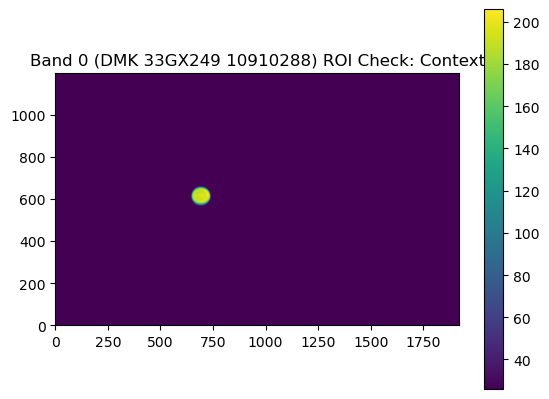

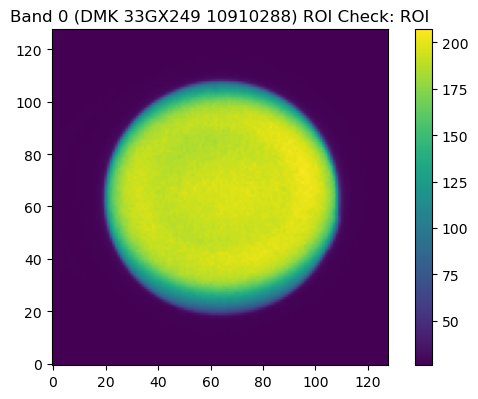

x: 243
y: 891


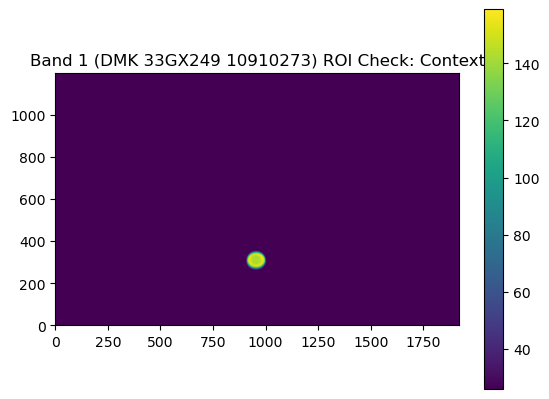

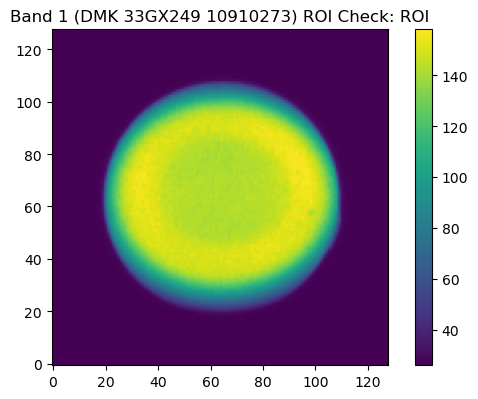

x: 229
y: 616


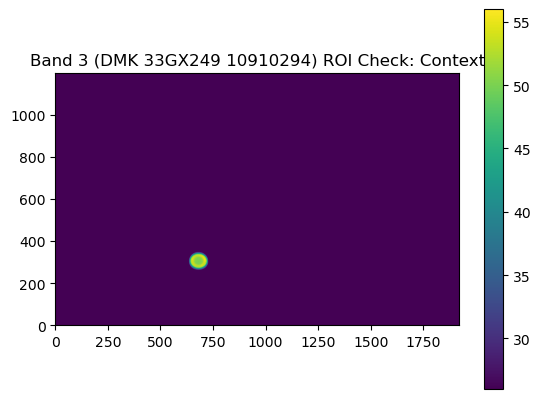

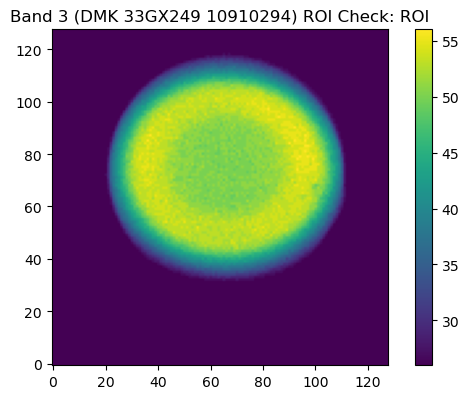

x: 531
y: 1178


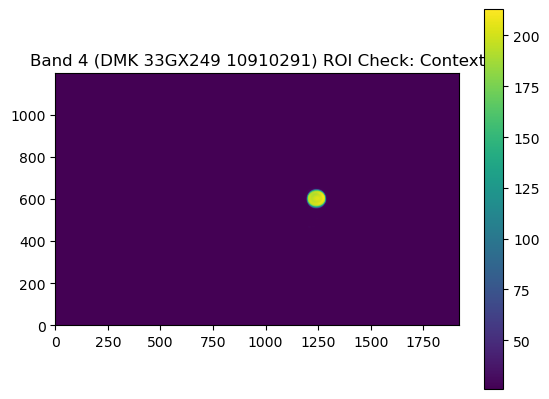

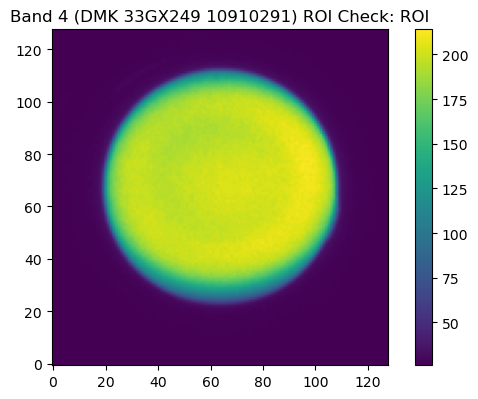

x: 870
y: 637


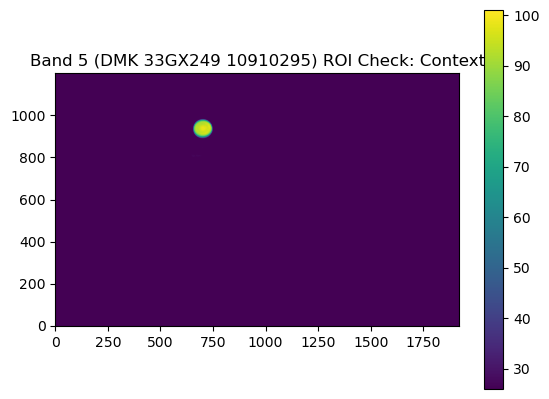

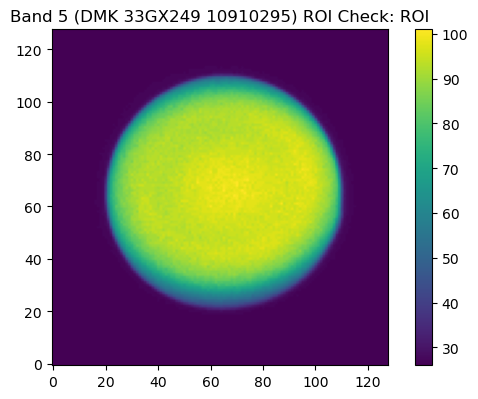

x: 866
y: 904


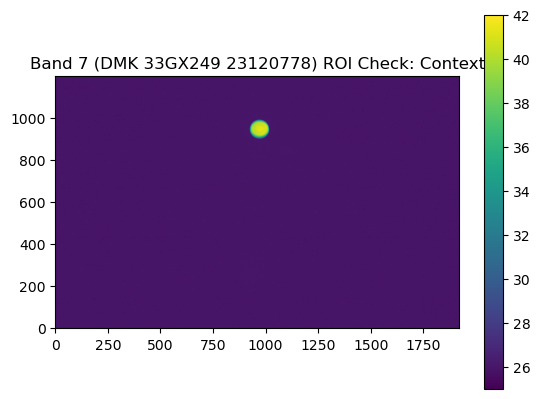

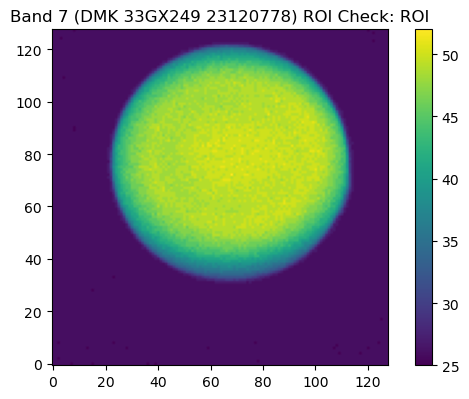

x: 241
y: 1179


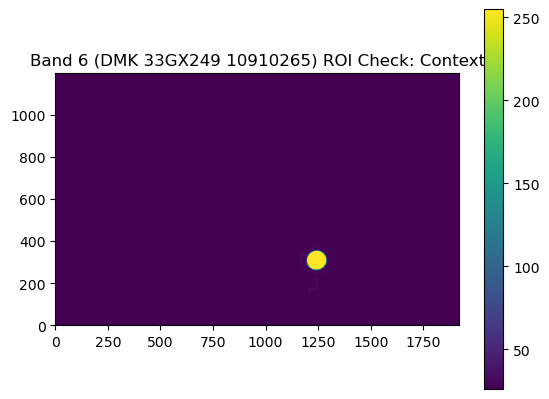

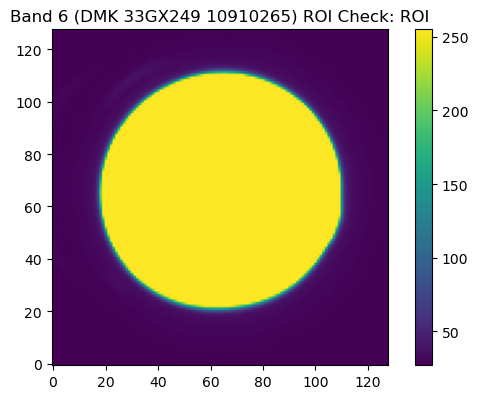

In [3]:
cameras = osc.find_camera_rois(connected_cameras, roi_size=128)

# Setting the F-Number

To set our cameras fo rthe given f-numbers, we need to:
- set the lens ring f-number to the minimum of f/1.4
- get the exposure required to image the reflectance target to a given exposure (150 DN) with high precision
- compute the exposure required to achieve the same level for the target f-number
- repeatedly adjust the ring until the value has been met.

In [10]:
connected_cameras[6].number

6

In [11]:
osc.set_f_numbers(connected_cameras[6:])

-----------------------------------
Device 6
-----------------------------------
Initiating search:
Exposure Auto set to 0
Exposure Value set to 0.0020000000949949026
Trial 0:
Quantile: 255.0, Target: 150
Exposure current Value: 0.0020000000949949026
Exposure Value set to 0.00023529412283096462
Exposure set to 0.00023499999952036887 (err of 2.9412930256084006e-07
Trial 1:
Quantile: 238.0, Target: 150
Exposure current Value: 0.00023499999952036887
Exposure Value set to 0.00014810924767516553
Exposure set to 0.00014800000644754618 (err of 1.0923694764426685e-07
Trial 2:
Quantile: 165.0, Target: 150
Exposure current Value: 0.00014800000644754618
Exposure Value set to 0.0001345454656984657
Exposure set to 0.0001340000017080456 (err of 5.454586988145704e-07
Trial 3:
Quantile: 141.0, Target: 150
Exposure current Value: 0.0001340000017080456
Exposure Value set to 0.00014255319547373801
Exposure set to 0.00014200000441633165 (err of 5.531888900998298e-07
Trial 4:
Quantile: 141.0, Target: 150
E

# Set Focus

In [23]:
osc.set_focus(connected_cameras)

-----------------------------------
Device 0
-----------------------------------
-----------------------------------
-----------------------------------
Device 1
-----------------------------------
-----------------------------------
-----------------------------------
Device 2
-----------------------------------
-----------------------------------
-----------------------------------
Device 3
-----------------------------------
-----------------------------------
-----------------------------------
Device 4
-----------------------------------
-----------------------------------
-----------------------------------
Device 5
-----------------------------------
-----------------------------------
-----------------------------------
Device 7
-----------------------------------
-----------------------------------
